# Capstone Project: COVID-19 Hospital Length of Stay Predictor

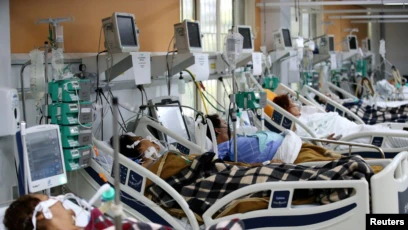

## I. Technical Summary

In this project, I create a predictive classification model geared towards a hospital's analytics team seeking to make informed decisions for resources and personnel allocation based on predicted inpatient length of stay. The target variable is classified into three labels: `"Short-Term"`, `"Medium-Term"`, and `"Long-Term"` based on the number of days a patient is predicted to stay. The model uses fourteen features to predict the length of stay -- with features such as `Type of Admission`, `Severity of Illness`, `Bed Grade`, and `Ward Type` having the most influence. The final model produced is an tuned `XGBoost model` that is able to predict length of stay with `54% accuracy`. With further research and implementation, classifiers like these could be used in emergency situations to properly allocate resources based on predictive knowledge of how long a patient is expected to admitted for. 

## II. The Motivation

It goes without saying that the onset of the COVID-19 virus has had a drastic impact on the world as we know it today. At the beginning of the pandemic, hospitals were overrun with patients needing medical attention and it became clear that hospital infrastructure was not equipped for this unprecedented event.

The motivation for this project came from a conversation I had with my roommate who is a nurse here in San Francisco who worked on a COVID unit during the pandemic. She told me that one of the biggest factors leading to inadequate care was the lack of hospital resources. Without proper resources, sick people were not able to receieve proper care. One of major contributing factors to this came from not knowing how long a patient would be hospitalized for when they are admitted. With such a huge influx of long-term residential patients, hospitals were quickly drained of resources such as PPE, certain medications, and even beds themselves. 

Predictive modeling has many applications in the healthcare field and I wanted to use this project as an opportunity to show how machine learning could be used to help alleviate the burden of this type of issue in the future. In this project, I build a classifier model that can be used to predict the length of stay (LOS) of a COVID-19 patient given certain predictive features. With further research and implementation, classifiers like these could be used in emergency situations to properly allocate resources based on predictive knowledge of how long a patient is expected to admitted for.

## III. Business Understanding

**Stakeholder**: Analytics team for a group of hospitals looking to predict length of stay (LOS) estimates for COVID-19 inpatients. 

**Problem**: Effectively predict the length of stay of a COVID-19 patient given similar past patient profiles in order to better allocate hospital resources and personnel. 

**Target**: Length of stay (LOS)
* Length of stay is defined as a categorical variable in this dataset broken into 10 day increments.
* In order to fit with my model, this was encoded using a LabelEncoder as follows:
    
| Label | # of Days |
| --- | --- |
| 0 | 0-10 Days |
| 1 | 11-20 Days |
| 2 | 21-30 Days |
| 3 | 31-40 Days |
| 4 | 41-50 Days |
| 5 | 51-60 Days |
| 6 | 61-70 Days |
| 7 | 71-80 Days |
| 8 | 81-90 Days |
| 9 | 91-100 Days |
| 10 | >100 Days |

* Upon further analysis of the data (discussed more in next section), I decided to group the labels into three categories: "Short-Term", "Medium-Term", and "Long-Term" by binning the data as follows: 

| Label | Type of Stay | # of Days |
| --- | --- | --- | 
| 0 | Short-Term | 0-20 Days |
| 1 | Medium-Term | 21-50 Days |
| 2 | Long-Term | > 51 Days |


My data came from a series of analytic healthcare data provided on Kaggle by Vidhya Healthcare Analytics to be used as a means of building and sharing predictive models for COVID-19 related projects.

The data was collected anonymously in order to protect the identity of the individuals and hospitals.

### Imports

In [24]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pylab as pl
%matplotlib inline 
sns.set(color_codes=True)

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from xgboost import XGBClassifier, plot_tree

## III. Data Exploration

### The Dataset

In [25]:
df_train = pd.read_csv('data/COVID-19_Train.csv')
df_train.head()

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50


In [26]:
# Check shape --> there are 318,248 patient entries and 18 feature columns including my target 'Stay'

df_train.shape

(318438, 18)

In [27]:
# Get info --> quick summary of what I am working with 

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   case_id                            318438 non-null  int64  
 1   Hospital_code                      318438 non-null  int64  
 2   Hospital_type_code                 318438 non-null  object 
 3   City_Code_Hospital                 318438 non-null  int64  
 4   Hospital_region_code               318438 non-null  object 
 5   Available Extra Rooms in Hospital  318438 non-null  int64  
 6   Department                         318438 non-null  object 
 7   Ward_Type                          318438 non-null  object 
 8   Ward_Facility_Code                 318438 non-null  object 
 9   Bed Grade                          318325 non-null  float64
 10  patientid                          318438 non-null  int64  
 11  City_Code_Patient                  3139

In [28]:
# Get data types --> int, float, and objects 

df_train.dtypes

case_id                                int64
Hospital_code                          int64
Hospital_type_code                    object
City_Code_Hospital                     int64
Hospital_region_code                  object
Available Extra Rooms in Hospital      int64
Department                            object
Ward_Type                             object
Ward_Facility_Code                    object
Bed Grade                            float64
patientid                              int64
City_Code_Patient                    float64
Type of Admission                     object
Severity of Illness                   object
Visitors with Patient                  int64
Age                                   object
Admission_Deposit                    float64
Stay                                  object
dtype: object

In [29]:
# Check for duplicates 

df_train.duplicated().sum()

0

### Feature Analysis

Below is an overview of the features, a description, and important notes pertaining to how the data points were recorded in the dataset:

| Feature | Description | Notes |
| --- | --- | --- |
| case_ID | Case ID registered in Hospital | 
| Hospital_code | Unique code for the Hospital | Codes 1-30 for 30 Hospitals included in data |
| Hospital_type_code | Unique code for the type of Hospital | Codes a-g for 7 types of hospitals included (e.g. general, research, etc.) |
| City_Code_Hospital | City Code of the Hospital | Codes 1-13 for 13 cities included in data |
| Hospital_region_code | Region Code of the Hospital | Codes X, Y, Z for three regions included in data |
| Available Extra Rooms in Hospital | Number of extra rooms available in the Hospital | 
| Department | Department overlooking the case | 
| Ward_Type | Unique code for the Ward type | Unique code P-U for type of Ward |
| Ward_Facility_Code | Unique code for the Ward facility | Unique code A-F for Ward facility |
| Bed Grade | Condition of bed in the Ward | Scale grade 1-4 |
| patientid | Unique patient ID number | 
| City_Code_Patient | City code for the patient | Codes 1-38 for 38 cities included in data |
| Type of Admission | Admission type registered by the Hospital | Categorized as Trauma, Emergency, or Urgent |
| Severity of Illness | Severity of the illness recorded at the time of admission | Categorized as Minor, Moderate, or Extreme |
| Visitors with Patient | Number of visitors with the patient | 
| Age | Age of patient |
| Admission_Deposit | Deposit made at time of admission |

Since my model is intended to predict length of stay at time of admission in order to place a patient effectively, I am going to remove features that do not have predictive applications: 

* `case_ID`, `patientid` --> simply information about unique patient code 
* `Visitors with Patient` --> more visitors could mean longer stay but this is not predictive
* `Hospital_region_code` --> region is covered by `City_Code_Hospital` and provides more detailed geographic importance.

In [30]:
df_train.drop(['case_id', 'patientid', 'Hospital_region_code', 'Visitors with Patient'], axis=1, inplace=True)
df_train.head()

,Hospital_code,Hospital_type_code,City_Code_Hospital,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,City_Code_Patient,Type of Admission,Severity of Illness,Age,Admission_Deposit,Stay
0,8,c,3,3,radiotherapy,R,F,2.0,7.0,Emergency,Extreme,51-60,4911.0,0-10
1,2,c,5,2,radiotherapy,S,F,2.0,7.0,Trauma,Extreme,51-60,5954.0,41-50
2,10,e,1,2,anesthesia,S,E,2.0,7.0,Trauma,Extreme,51-60,4745.0,31-40
3,26,b,2,2,radiotherapy,R,D,2.0,7.0,Trauma,Extreme,51-60,7272.0,41-50
4,26,b,2,2,radiotherapy,S,D,2.0,7.0,Trauma,Extreme,51-60,5558.0,41-50


In [31]:
# Summary statistics for the numerical variables 

df_train.describe()

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,City_Code_Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318325.000000,313906.000000,318438.000000
mean,18.318841,4.771717,3.197627,2.625807,7.251859,4880.749392
std,8.633755,3.102535,1.168171,0.873146,4.745266,1086.776254
min,1.000000,1.000000,0.000000,1.000000,1.000000,1800.000000
25%,11.000000,2.000000,2.000000,2.000000,4.000000,4186.000000
50%,19.000000,5.000000,3.000000,3.000000,8.000000,4741.000000
75%,26.000000,7.000000,4.000000,3.000000,8.000000,5409.000000
max,32.000000,13.000000,24.000000,4.000000,38.000000,11008.000000


Some features seem to have some skew and the low minumum values should be checked as outliers. Let's start out by doing a little data cleaning before jumping into my analysis.

### Data Cleaning: First Steps

In [32]:
# Check missing values --> Bed Grade & City_Code_Patient 

df_train.isna().sum()

Hospital_code                           0
Hospital_type_code                      0
City_Code_Hospital                      0
Available Extra Rooms in Hospital       0
Department                              0
Ward_Type                               0
Ward_Facility_Code                      0
Bed Grade                             113
City_Code_Patient                    4532
Type of Admission                       0
Severity of Illness                     0
Age                                     0
Admission_Deposit                       0
Stay                                    0
dtype: int64

In [33]:
# Fill 'Bed Grade' and 'City_Code_Patient' missing values with mode due to outliers causing skew in data 

df_train['Bed Grade'].fillna(df_train['Bed Grade'].mode()[0], inplace=True)
df_train['City_Code_Patient'].fillna(df_train['City_Code_Patient'].mode()[0], inplace=True)

df_train.isna().sum()

Hospital_code                        0
Hospital_type_code                   0
City_Code_Hospital                   0
Available Extra Rooms in Hospital    0
Department                           0
Ward_Type                            0
Ward_Facility_Code                   0
Bed Grade                            0
City_Code_Patient                    0
Type of Admission                    0
Severity of Illness                  0
Age                                  0
Admission_Deposit                    0
Stay                                 0
dtype: int64

### Data Cleaning: Target Analysis

Let's first take a look at the target variable 'Stay' in the data set to see the distribution of values:

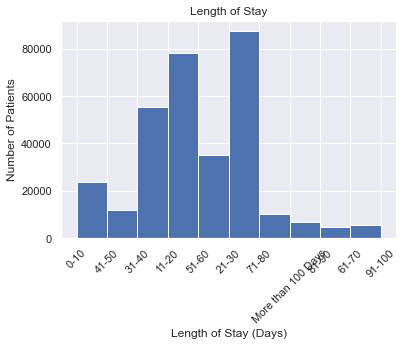

21-30                 87491
11-20                 78139
31-40                 55159
51-60                 35018
0-10                  23604
41-50                 11743
71-80                 10254
More than 100 Days     6683
81-90                  4838
91-100                 2765
61-70                  2744
Name: Stay, dtype: int64

In [38]:
plt.hist(df_train['Stay'])
plt.xticks(rotation=45)
plt.xlabel('Length of Stay (Days)')
plt.ylabel('Number of Patients')
plt.title('Length of Stay')
plt.show()
df_train['Stay'].value_counts()

We can see that the vast majority of patients are hospitalized for less than 60 days. In the context of my problem, I want to help hospitals allocate resources and personnel effectively. In doing so, it may not be necessary to have 10 different prediction labels and instead am going to separate into three types of stay: 

I am going to bin the target label into three categories based on length of stay:

* **Short-Term**: less than 20 days
    * Quick turnaround for hospital 
    * Less personnel & resources 
    * Lower risk for long-term complications and/or death 

* **Medium-Term**: 21 to 60 days 
    * More intensive care
    * Moderate use of personnel & resources 
    * Increased risk for long-term complications and/or death

* **Long-Term**: more than 60 days 
    * Most intensive care 
    * Heavy use of personnel & resources 
    * Significant risk for long-term complications and/or death

In [ ]:
df_train['Stay']= df_train['Stay'].replace({'0-10':0, '11-20':0, 
                                         '21-30':1, '31-40':1, '41-50':1, 
                                         '51-60':2,'61-70':2,'71-80':2,'81-90':2,'91-100':2,'More than 100 Days':2})

df_train['Stay']

Let's check out the new distributions:

In [ ]:
plt.hist(df_train['Stay'],)
df_train['Stay'].value_counts()

We can see with the new distributions that there is much less class imbalance which will allow my model to have an easier time predicting the minority classes. This works with the context of the problem as well since 10 day increments aren't necessarily the best for a length of stay analysis.

In [ ]:
plt.hist(df_train['Hospital_code'])
df_train['Hospital_code'].value_counts()

In [ ]:
plt.hist(df_train['Hospital_type_code'])
df_train['Hospital_type_code'].value_counts()

In [ ]:
plt.hist(df_train['City_Code_Hospital'])
df_train['City_Code_Hospital'].value_counts()

In [ ]:
plt.hist(df_train['Hospital_region_code'])
df_train['Hospital_region_code'].value_counts()

In [ ]:
plt.hist(df_train['Available Extra Rooms in Hospital'])
df_train['Available Extra Rooms in Hospital'].value_counts()

In [ ]:
plt.hist(df_train['Department'])
df_train['Department'].value_counts()

In [ ]:
plt.hist(df_train['Ward_Type'])
df_train['Ward_Type'].value_counts()

In [ ]:
plt.hist(df_train['Ward_Facility_Code'])
df_train['Ward_Facility_Code'].value_counts()

In [ ]:
plt.hist(df_train['Bed Grade'])
df_train['Bed Grade'].value_counts()

In [ ]:
plt.hist(df_train['City_Code_Patient'])
df_train['City_Code_Patient'].value_counts()

In [ ]:
plt.hist(df_train['Type of Admission'])
df_train['Type of Admission'].value_counts()

In [ ]:
plt.hist(df_train['Severity of Illness'])
df_train['Severity of Illness'].value_counts()

In [ ]:
plt.hist(df_train['Visitors with Patient'])
df_train['Visitors with Patient'].value_counts()

In [ ]:
plt.hist(df_train['Age'])
df_train['Age'].value_counts()

In [ ]:
plt.hist(df_train['Admission_Deposit'])
df_train['Admission_Deposit'].value_counts()

In [ ]:
# Split data into numerical and categorical categories 

num_data = df_train[['Hospital_code', 'City_Code_Hospital', 'Available Extra Rooms in Hospital', 'Bed Grade', 'City_Code_Patient', 'Admission_Deposit']]
cat_data = df_train[['Hospital_type_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age', 'Stay']]


### Exploratory Data Analysis (EDA)

Want to do more Visualizations once I complete the modeling steps. 

In [ ]:
# Categorical data quick analysis 

i=1
plt.figure(figsize=(15,20))
for col in cat_data:
    plt.subplot(5,2,i)
    sns.countplot(df_train[col])
    i=i+1
plt.show()

In [ ]:
# Numerical data quick analysis 

i=1
plt.figure(figsize=(15,20))
for col in num_data:
    plt.subplot(5,2,i)
    sns.distplot(df_train[col], bins=30)
    i=i+1
plt.show()

# df.hist(bins=30, figsize=(15, 10))

### Label Encoding Categorical Data

In order to use the categorical variables in my model, I have implemented the `LabelEncoder()` to give each variable a unique value:

In [ ]:
labels = LabelEncoder()

for col in cat_data:
    df_train[col]= labels.fit_transform(df_train[col])

df_train.head()

In [ ]:
df_train.dtypes

In [ ]:
# Check to see if there are any autocorrelation issues in dataset

plt.figure(figsize=(15,15))
sns.heatmap(df_train.corr(), annot=True)

## IV. Modeling

### Pre-Processing

In [ ]:
# Scale numeric predictors using StandardScaler()

scaler = StandardScaler()

for col in num_data:
    df_train[col]= scaler.fit_transform(df_train[col].values.reshape(-1,1))

df_train.head()

In [ ]:
# Separate target 'Stay' from predictors 

y = df_train['Stay']
X = df_train.drop('Stay', axis=1)

#print(y)
#print(X)

In [ ]:
# Train-test split using test_size = 0.2

X_train, X_test, y_train, y_test= train_test_split(X,y,test_size= 0.2, random_state=42)

### Model 1: Decision Tree

In [ ]:
dt_clf = DecisionTreeClassifier()
dt_model = dt_clf.fit(X_train, y_train)

dt_y_preds = dt_clf.predict(X_test)

In [ ]:
# print(confusion_matrix(y_test, rf_y_preds))
print(classification_report(y_test, dt_y_preds))

accuracy = accuracy_score(y_test, dt_y_preds)
print(accuracy)

### Model 2: Random Forest

In [ ]:
rf_clf = RandomForestClassifier()
rf_model = rf_clf.fit(X_train, y_train)

rf_y_preds = rf_clf.predict(X_test)

scores = cross_val_score(clf, X, y, cv=5)

In [ ]:
# print(confusion_matrix(y_test, rf_y_preds))
print(classification_report(y_test, rf_y_preds))

accuracy = accuracy_score(y_test, rf_y_preds)
print(accuracy)

### Model 3: KNeighbors 

In [ ]:
knn_clf = KNeighborsClassifier()
knn_model = knn_clf.fit(X_train, y_train)

knn_y_preds = knn_clf.predict(X_test)

In [ ]:
# print(confusion_matrix(y_test, rf_y_preds))
print(classification_report(y_test, knn_y_preds))

accuracy = accuracy_score(y_test, knn_y_preds)
print(accuracy)

### Model 4: XGBoost

In [ ]:
xgb_clf = XGBClassifier()
xgb_model = xgb_clf.fit(X_train, y_train)

cv_score = np.mean(cross_val_score(xgb_clf, X_train, y_train, cv=5))
cv_score

In [ ]:
xgb_y_preds = xgb_clf.predict(X_test)

In [ ]:
# print(confusion_matrix(y_test, rf_y_preds))
print(classification_report(y_test, xgb_y_preds))

accuracy = accuracy_score(y_test, xgb_y_preds)
print(accuracy)

In [ ]:
# Feature importance function taken from class lecture 

def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [ ]:
plot_feature_importances(xgb_clf)

This will be interesting to discuss in my findings and limitations. Also curious to mess around with removing visitors with patient. Will look into this more.

I also am interested in doing some feature engineering. 

### XGBoost Hyperparameter Tuning

In [ ]:
param_grid = {
    'max_depth': [1, 3, 5, 10],
    'subsample': [0.2, 0.3, 0.4, 0.5],
    'n_estimators': [100, 200, 500, 600],
}

grid_xgb = RandomizedSearchCV(xgb_clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_xgb.fit(X_train, y_train)

best_parameters = grid_xgb.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_xgb.predict(X_train)
test_preds = grid_xgb.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

In [ ]:
grid_xgb.best_estimator_

### Final Model

In [ ]:
xgb_clf_final = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, monotone_constraints='()',
              n_estimators=650, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.4,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_model_final = xgb_clf_final.fit(X_train, y_train)

cv_score_final = np.mean(cross_val_score(xgb_clf_final, X_train, y_train, cv=5))
cv_score_final

In [ ]:
xgb_y_preds = xgb_clf.predict(X_test)

In [ ]:
# print(confusion_matrix(y_test, rf_y_preds))
print(classification_report(y_test, xgb_y_preds))

accuracy = accuracy_score(y_test, xgb_y_preds)
print(accuracy)

In [ ]:
plot_feature_importances(xgb_clf)

In [ ]:
sns.countplot(xgb_y_preds)

In [ ]:
(unique, counts) = np.unique(xgb_y_preds, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print(frequencies)

In [ ]:
y_test.value_counts().sort_values()

### Results

Need to continue working on hyperparameters since what I've had so far was taking too long. Will look into more fine-tuning here...But without hyperparamters a 42.3% accuracy score which is low but in the context of the problem can still have an impact. 

### Future Research